In [28]:
from DataLoader import HeartFailureDataset
import pandas as pd
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns

load_data = HeartFailureDataset()
X = load_data.get_features()
y = load_data.get_targets()

First, we examine our dataset by considering the values of the dependent variable $y$. The target variable $y \in \{0,1\}$ is binary and takes on the following values:

<div style="text-align: center;">

$$
y = \begin{cases}
1 & \text{indicates a death event} \\
0 & \text{indicates survival}
\end{cases}
$$

</div>

We have $n = 300$ many data points and $d = 12$ different "features":

    1. Age; patient age, in years
    2. Anemia; decrease in red blood cells or hemoglobin,
    3. Creatinine; CPK enzyme levels in the blood (mcg/L),
    4. Diabetes; whether the patient is diabetic,
    5. Ejection fraction (EF); the percentage of blood that leaves the heart with each contraction
    6. High blood pressure; whether the patient has hypertension
    7. Platelets; platelets in the blood (kilo platelets/mL)
    8. Serum creatinine; serum creatinine level in the blood (mg/dL)
    9. Serum sodium; serum sodium level in the blood (mEq/L)
    10. Sex (gender); male or female
    11. Smoking; whether the patient smokes or not
    12. Time; Patient follow-up time in days
We store the Features in a $300 \times 12$ matrix $X$.

In [29]:
y

,death_event
0,1
1,1
2,1
3,1
4,1
...,...
294,0
295,0
296,0
297,0


In [30]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np

z = zscore(X)
z_df = pd.DataFrame(z, columns=X.columns)
is_outlier = (np.abs(z_df) > 4).any(axis=1)
is_outlier
num_outliers = is_outlier.sum()
print(f"Anzahl der Ausreißer: {num_outliers}")

Anzahl der Ausreißer: 14


## TODO

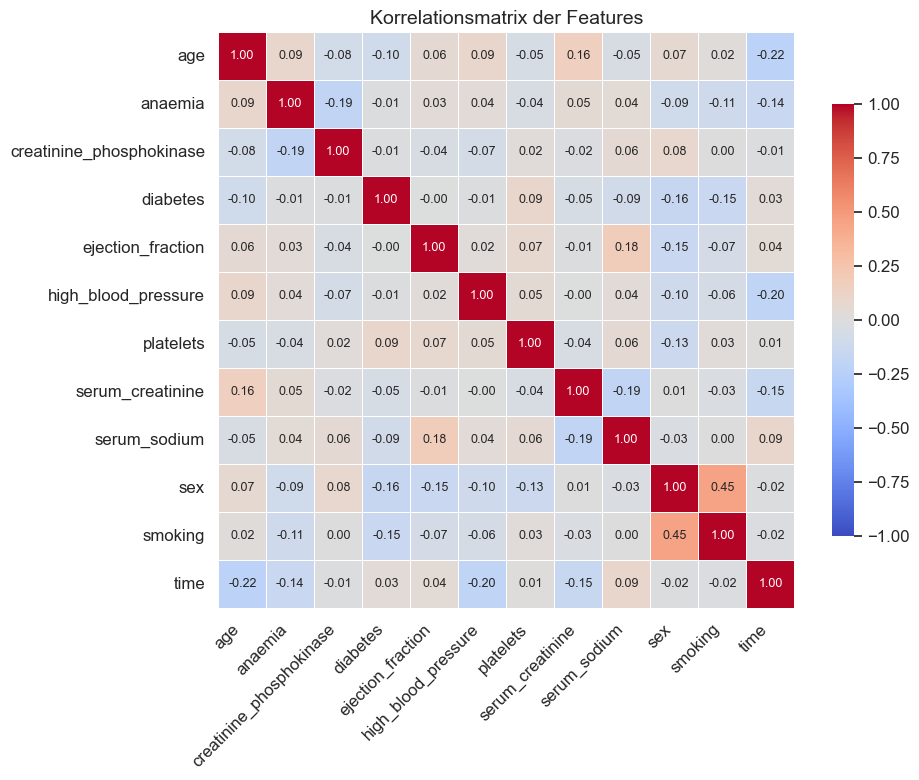

In [31]:
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))  # Mehr Platz für 12 Features
sns.set(font_scale=1.1)  # Größere Schrift für bessere Lesbarkeit
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",  # zwei Nachkommastellen
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={"shrink": 0.75},  # Farbleiste etwas kleiner
    linewidths=0.5,  # Gitterlinien zwischen Feldern
    annot_kws={"size": 9},  # Schriftgröße der Zahlen in den Feldern
)
plt.xticks(rotation=45, ha='right')  # Achsenbeschriftung lesbarer machen
plt.yticks(rotation=0)
plt.title("Korrelationsmatrix der Features", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_31256\352138154.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\User\AppData\Local\Temp\ipykernel_31256\352138154.py:9: UserWarning: 
The palette list has fewer values (6) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


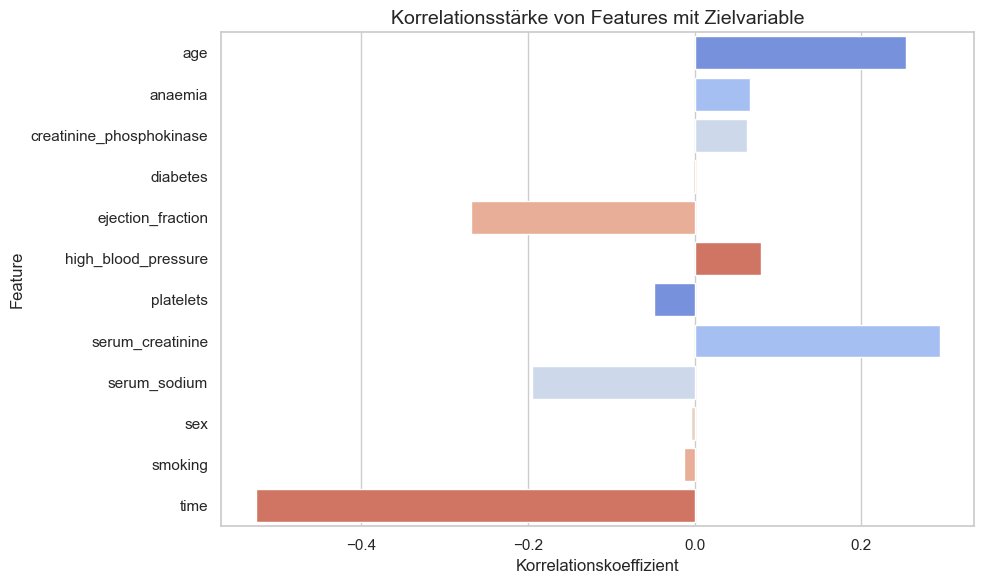

In [32]:
from scipy.stats import pointbiserialr


y_new = y.iloc[:, 0]
correlations = X.corrwith(y_new)
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(
    x=correlations.values,
    y=correlations.index,
    palette=sns.color_palette("coolwarm"),
    orient='h')

# 4. Titel und Achsen
plt.title("Korrelationsstärke von Features mit Zielvariable", fontsize=14)
plt.xlabel("Korrelationskoeffizient", fontsize=12)
plt.ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.show()

We can remove the feature "time".

In [33]:
X = X.drop(columns="time")

Next we aim to scale our data. As a first step we take a look at the histograms to determine different range of values.

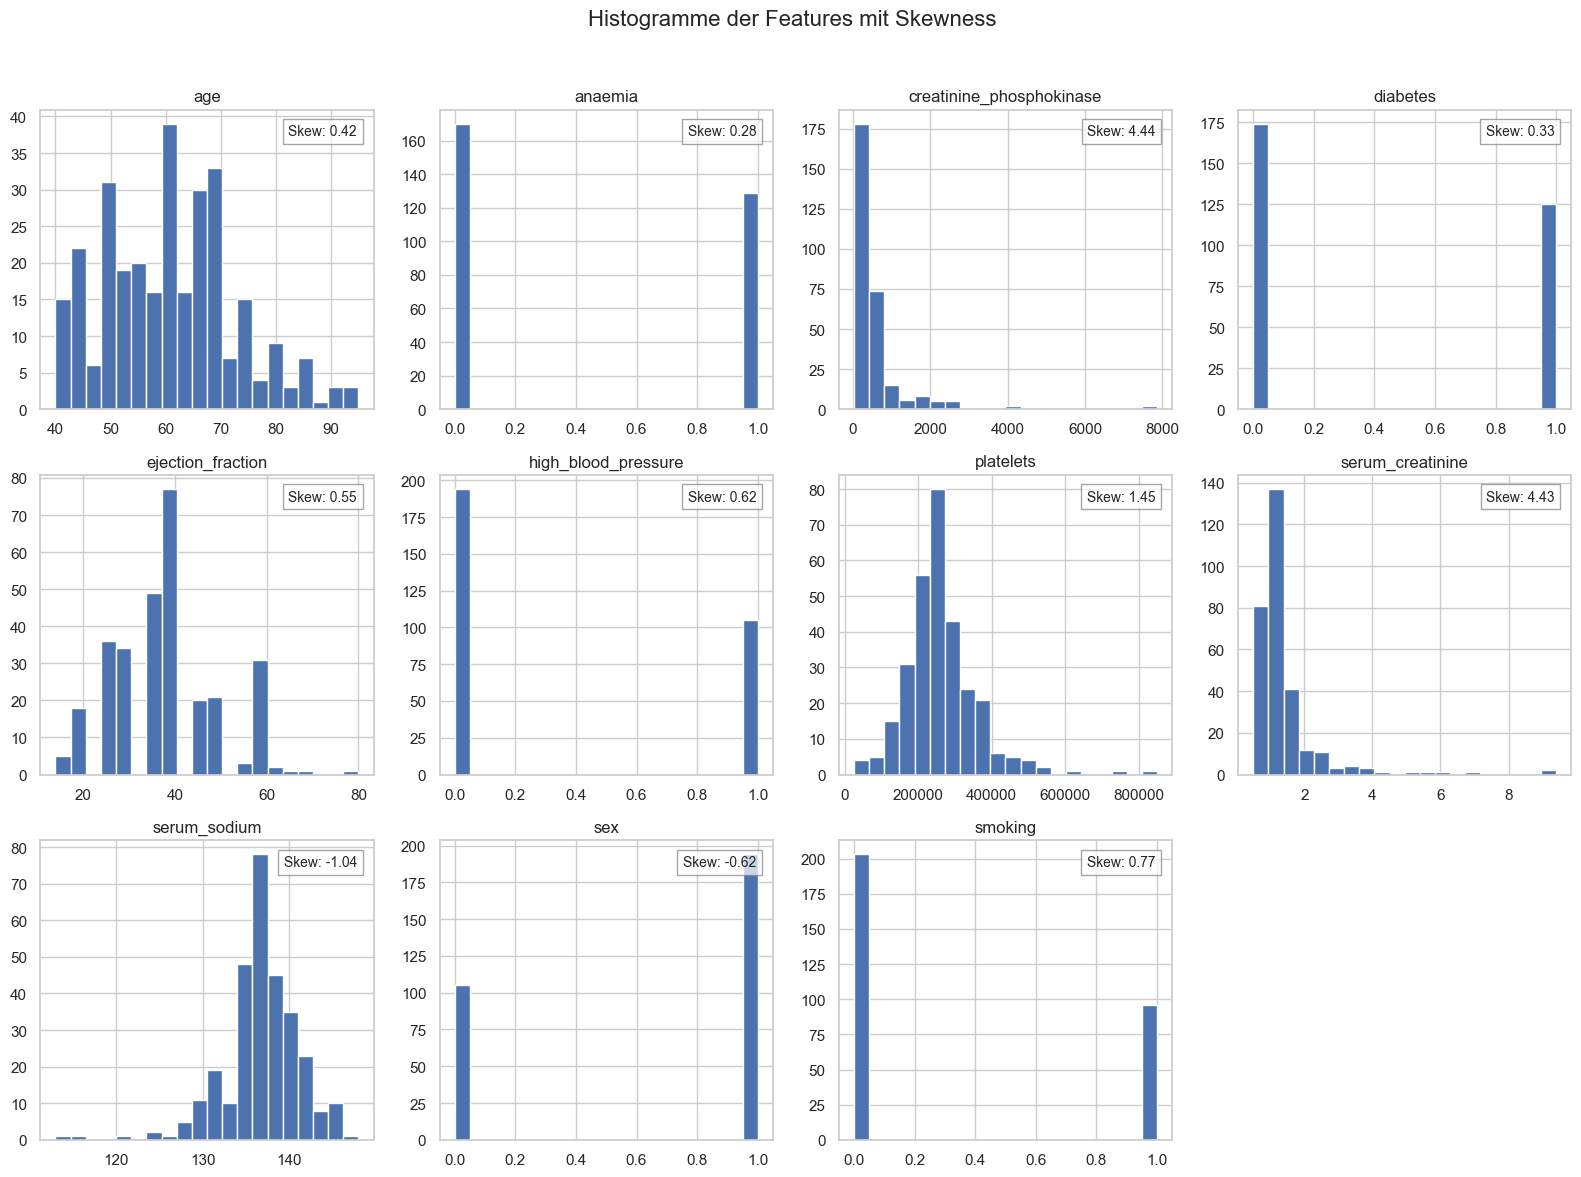

In [34]:
import matplotlib.pyplot as plt
from scipy.stats import skew
import numpy as np

# Anzahl der Spalten im Plot-Raster
cols = 4
rows = int(np.ceil(len(X.columns) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    ax = axes[i]
    X[col].hist(bins=20, ax=ax)
    ax.set_title(col)
    
    # Skewness berechnen und anzeigen
    sk = skew(X[col].dropna())
    ax.text(0.95, 0.95, f"Skew: {sk:.2f}", 
            transform=ax.transAxes, 
            fontsize=10, 
            verticalalignment='top', 
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# Leere Subplots ausblenden (falls z. B. 10 Plots aber 12 Felder)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Histogramme der Features mit Skewness", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Man kann sehen, dass creatine_phospokinase "skewed" vorliegt. Die Daten sind rechtsschief. Deshalb wenden wir eine Box-Cox Transformation mit $\lambda = 0 \rightarrow$ Log-Transformation.

In [35]:
from scipy.stats import skew

print('Skewness creatine_phospokinase: ', skew(X['creatinine_phosphokinase']))

X['creatinine_phosphokinase'] = np.log(X['creatinine_phosphokinase']+1)

print('Skewness after log-Transformation: ', skew(X['creatinine_phosphokinase']))


Skewness creatine_phospokinase:  4.440688625555512
Skewness after log-Transformation:  0.42059187973291207


Wir müssen unsere Daten also skalieren!
Um unsere Ergebnisse besser interpretieren zu können, skalieren wir alle nichtbinären feature mit dem Standscaler()

Die Standardisierung erfolgt für jedes numerische Feature $x$ nach folgender Formel:


$x_{\text{scaled}} = \frac{x - \mu}{\sigma}$


- $ \mu $: Mittelwert des Features in den Trainingsdaten  
- $ \sigma $: Standardabweichung des Features in den Trainingsdaten

Für die binären Features wird keine Veränderung vorgenommen, sie bleiben unverändert.

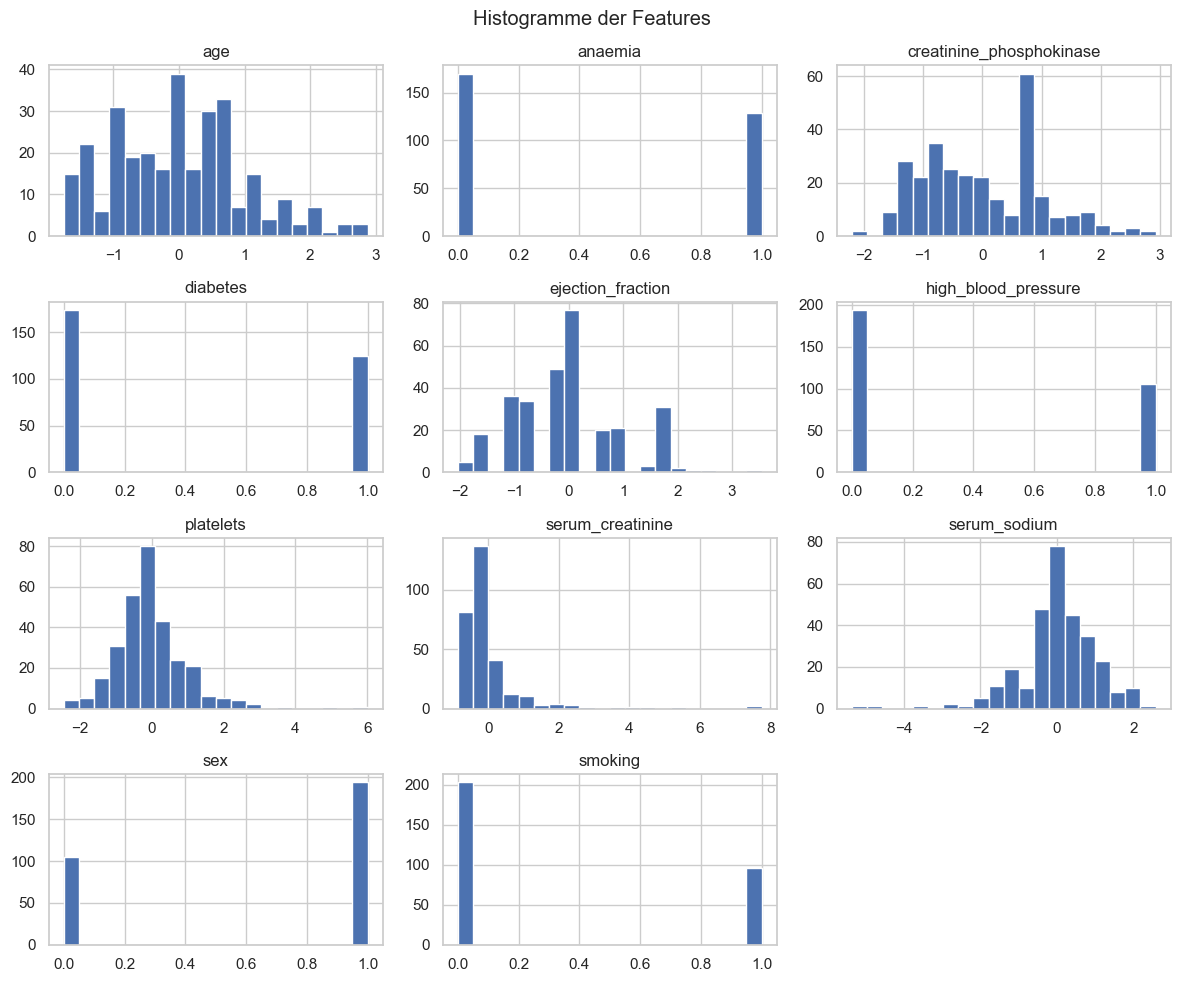

In [36]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['age', 'creatinine_phosphokinase',
       'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium']
scaler = StandardScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.hist(bins=20, figsize=(12, 10))
plt.suptitle("Histogramme der Features")
plt.tight_layout()
plt.show()

In [37]:
X.to_pickle('X.pkl')
y.to_pickle('y.pkl')